# Curling Analytics - Scoreboard Management Analysis

### Context

Scoreboard management in curling refers to managing the score and the hammer of the future ends. The team that has the hammer (last stone of the end) has the advantage to score. Once a team scores, the team that did not score in the preceding end has the hammer. If neither team scores, called a blanked end, the hammer remains with the same team.

Because of the tactical value of the hammer, the team with the hammer aims to score more than multiple points or to blank the end to keep the hammer. Teams also tends to keep the hammer in even ends so that the team will have the hammer in the last end. Often, teams need to decide how much to score with the hammer in the last few ends to maximize the chance to win.

In this analysis, I’m trying to explore how much games are won under different ends, score difference, and with or without hammer. For example, I want to how many/what percentage of games are won when at the beginning of End 8, the team with hammer is leading with 1 point?

### Preparation

In [1]:
import os
import pandas as pd
import numpy as np
import database_functions as db
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
os.environ["CADBPATH"]=os.getcwd() + "\\curling_data.db"

### Get data
In the following query, I will retrieve a dataframe that contains the information of each ends played with the final result of the game.

The field I need:
+ Game id
+ Event name
+ Type of the game (Men's/Women's) for later analysis
+ Final score of the game
+ The number of ends
+ Which team has the hammer
+ Scores of the end

In [4]:
q='''SELECT games.id AS game_id, events.name AS event_name, games.type,
games.final_score_red, games.final_score_yellow, ends.number AS end_no, ends.color_hammer,
ends.score_red AS end_score_red, ends.score_yellow AS end_score_yellow
FROM games
INNER JOIN ends ON games.id = ends.game_id
INNER JOIN events ON games.event_id = events.id
WHERE games.final_score_red != 'NaN' AND final_score_yellow != "NaN";'''

df = db.run_query(q)
df

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow
0,169,CUR_ECC2016P,Men,4,6,1,red,1.0,0.0
1,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,1.0
2,169,CUR_ECC2016P,Men,4,6,3,red,2.0,1.0
3,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,2.0
4,169,CUR_ECC2016P,Men,4,6,5,red,2.0,3.0
...,...,...,...,...,...,...,...,...,...
10806,1352,CUR_WWCC2019P,Women,9,7,6,red,7.0,3.0
10807,1352,CUR_WWCC2019P,Women,9,7,7,yellow,7.0,5.0
10808,1352,CUR_WWCC2019P,Women,9,7,8,red,8.0,5.0
10809,1352,CUR_WWCC2019P,Women,9,7,9,yellow,8.0,7.0


### Data cleasing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10811 entries, 0 to 10810
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             10811 non-null  int64  
 1   event_name          10811 non-null  object 
 2   type                10811 non-null  object 
 3   final_score_red     10811 non-null  int64  
 4   final_score_yellow  10811 non-null  int64  
 5   end_no              10811 non-null  int64  
 6   color_hammer        10811 non-null  object 
 7   end_score_red       10673 non-null  float64
 8   end_score_yellow    10673 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 760.3+ KB


The dataframe has 138 empty rows for the scores of the ends. This is proabably due to an error when parsing the pdf reports. Since the missing data only consists a small portion of the dataset, I will drop all the empty rows.

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10673 entries, 0 to 10810
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             10673 non-null  int64  
 1   event_name          10673 non-null  object 
 2   type                10673 non-null  object 
 3   final_score_red     10673 non-null  int64  
 4   final_score_yellow  10673 non-null  int64  
 5   end_no              10673 non-null  int64  
 6   color_hammer        10673 non-null  object 
 7   end_score_red       10673 non-null  float64
 8   end_score_yellow    10673 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 833.8+ KB


Now, the end_score column represent the scores when the end is finished. Therefore, the following is used to tranform the data:
+ Shift the hammer team up 1 row
+ Drop the last end of the game
+ Add one to the end number
Now, the end scores and hammer team represent the situation of the beginning of the end instead of when the end is finished.

In [7]:
df['color_hammer'] = df['color_hammer'].shift(periods=-1, fill_value=0)
df.drop(df.index[df.groupby('game_id')['end_no'].transform(max) == df['end_no']], inplace=True)
df['end_no'] = df['end_no']+1

Calculate the score difference for both team with hammer and the team with the first stone.

In [8]:
df['score_diff_hmr'] = np.where(df['color_hammer']=='red', df['end_score_red']-df['end_score_yellow'], df['end_score_yellow']-df['end_score_red'])
df['score_diff_fs'] = np.where(df['color_hammer']=='yellow', df['end_score_red']-df['end_score_yellow'], df['end_score_yellow']-df['end_score_red'])
df

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
10805,1352,CUR_WWCC2019P,Women,9,7,6,red,5.0,3.0,2.0,-2.0
10806,1352,CUR_WWCC2019P,Women,9,7,7,yellow,7.0,3.0,-4.0,4.0
10807,1352,CUR_WWCC2019P,Women,9,7,8,red,7.0,5.0,2.0,-2.0
10808,1352,CUR_WWCC2019P,Women,9,7,9,yellow,8.0,5.0,-3.0,3.0


Determine if the game is won by the team with hammer or team with the first stone.

In [9]:
df['winner_hmr'] = np.where(((df['color_hammer']=='red') & (df['final_score_red']>df['final_score_yellow']))|((df['color_hammer']=='yellow') & (df['final_score_red']<df['final_score_yellow'])),1,0)
df['winner_fs'] = np.where(((df['color_hammer']=='red') & (df['final_score_red']<df['final_score_yellow']))|((df['color_hammer']=='yellow') & (df['final_score_red']>df['final_score_yellow'])),1,0)
df.head(100)

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0,1,0
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0,0,1
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0,1,0
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0,0,1
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0,0,1
5,169,CUR_ECC2016P,Men,4,6,7,yellow,3.0,3.0,0.0,0.0,1,0
6,169,CUR_ECC2016P,Men,4,6,8,red,3.0,5.0,-2.0,2.0,0,1
7,169,CUR_ECC2016P,Men,4,6,9,yellow,4.0,5.0,1.0,-1.0,1,0
8,169,CUR_ECC2016P,Men,4,6,10,yellow,4.0,5.0,1.0,-1.0,1,0
10,170,CUR_ECC2016P,Men,3,10,2,yellow,0.0,0.0,0.0,0.0,1,0


Check the distribution of the score differences

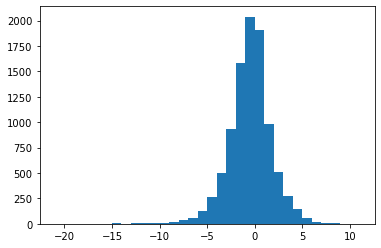

In [10]:
x1 = df['score_diff_hmr']
fig = plt.hist(x1,bins=int(x1.max()-x1.min()))

In [11]:
x1.value_counts()

-1.0     2038
 0.0     1906
-2.0     1586
 1.0      987
-3.0      933
 2.0      510
-4.0      501
 3.0      278
-5.0      268
 4.0      147
-6.0      125
 5.0       62
-7.0       54
-8.0       34
 6.0       13
-9.0       13
-10.0      11
-11.0       9
 7.0        8
 8.0        7
-12.0       5
-15.0       3
-13.0       3
 9.0        2
-14.0       2
-19.0       1
-21.0       1
 10.0       1
 11.0       1
Name: score_diff_hmr, dtype: int64

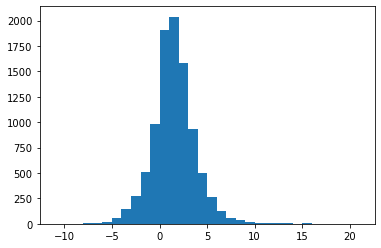

In [12]:
x2 = df['score_diff_fs']
fig = plt.hist(x2,bins=int(x2.max()-x2.min()))

In [13]:
x2.value_counts()

 1.0     2038
 0.0     1906
 2.0     1586
-1.0      987
 3.0      933
-2.0      510
 4.0      501
-3.0      278
 5.0      268
-4.0      147
 6.0      125
-5.0       62
 7.0       54
 8.0       34
-6.0       13
 9.0       13
 10.0      11
 11.0       9
-7.0        8
-8.0        7
 12.0       5
 15.0       3
 13.0       3
-9.0        2
 14.0       2
 19.0       1
 21.0       1
-10.0       1
-11.0       1
Name: score_diff_fs, dtype: int64

As we can see from the figures and tables, the data has a rather wide spread but there are few data in both tails. Therefore, I will collapse both tails and combine them to +/-4.

In [14]:
x = df['score_diff_hmr']
con = [x<-4, (x>=-4) & (x<=4), x>4]
choice = [-4,x,4]
df['score_diff_hmr'] = np.select(con,choice)

In [15]:
x = df['score_diff_fs']
con = [x<-4, (x>=-4) & (x<=4), x>4]
choice = [-4,x,4]
df['score_diff_fs'] = np.select(con,choice)

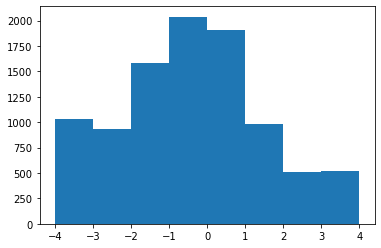

In [16]:
x1 = df['score_diff_hmr']
fig = plt.hist(x1,bins=int(x1.max()-x1.min()))

In [17]:
x1.value_counts()

-1.0    2038
 0.0    1906
-2.0    1586
-4.0    1030
 1.0     987
-3.0     933
 2.0     510
 3.0     278
 4.0     241
Name: score_diff_hmr, dtype: int64

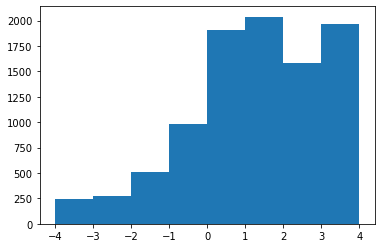

In [18]:
x2 = df['score_diff_fs']
fig = plt.hist(x2,bins=int(x2.max()-x2.min()))

In [19]:
x2.value_counts()

 1.0    2038
 0.0    1906
 2.0    1586
 4.0    1030
-1.0     987
 3.0     933
-2.0     510
-3.0     278
-4.0     241
Name: score_diff_fs, dtype: int64

Attaching the total counts of each combination of hammer, end number, and score differences to the dataframe for calucating percetages later

In [20]:
df['count_hmr'] = df.groupby(['end_no','score_diff_hmr'])['winner_hmr'].transform('count')
df['count_fs'] = df.groupby(['end_no','score_diff_fs'])['winner_fs'].transform('count')
df.head(100)

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs,count_hmr,count_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0,1,0,435,435
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0,0,1,285,285
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0,1,0,261,261
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0,0,1,199,199
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0,0,1,184,184
5,169,CUR_ECC2016P,Men,4,6,7,yellow,3.0,3.0,0.0,0.0,1,0,168,168
6,169,CUR_ECC2016P,Men,4,6,8,red,3.0,5.0,-2.0,2.0,0,1,139,139
7,169,CUR_ECC2016P,Men,4,6,9,yellow,4.0,5.0,1.0,-1.0,1,0,99,99
8,169,CUR_ECC2016P,Men,4,6,10,yellow,4.0,5.0,1.0,-1.0,1,0,107,107
10,170,CUR_ECC2016P,Men,3,10,2,yellow,0.0,0.0,0.0,0.0,1,0,324,324


In [21]:
df.groupby(['end_no','score_diff_hmr']).count()

game_id  event_name  type  final_score_red  \
end_no score_diff_hmr                                               
2      -4.0                 25          25    25               25   
       -3.0                 88          88    88               88   
       -2.0                276         276   276              276   
       -1.0                435         435   435              435   
        0.0                324         324   324              324   
3      -4.0                 67          67    67               67   
       -3.0                 93          93    93               93   
       -2.0                218         218   218              218   
       -1.0                309         309   309              309   
        0.0                285         285   285              285   
        1.0                119         119   119              119   
        2.0                 49          49    49               49   
        3.0                  5           5     5                5   
        4.0                  3           3     3                3   
4      -4.0                112         112   112              112   
       -3.0                119         119   119              119   
       -2.0                224         224   224              224   
       -1.0                261         261   261              261   
        0.0                223         223   223              223   
        1.0                131         131   131              131   
        2.0                 48          48    48               48   
        3.0                 19          19    19               19   
        4.0                 11          11    11               11   
5      -4.0                170         170   170              170   
       -3.0                119         119   119              119   
       -2.0                178         178   178              178   
       -1.0                223         223   223              223   
        0.0                199         199   199              199   
        1.0                147         147   147              147   
        2.0                 54          54    54               54   
        3.0                 27          27    27               27   
        4.0                 31          31    31               31   
6      -4.0                198         198   198              198   
       -3.0                130         130   130              130   
       -2.0                158         158   158              158   
       -1.0                184         184   184              184   
        0.0                177         177   177              177   
        1.0                131         131   131              131   
        2.0                 70          70    70               70   
        3.0                 45          45    45               45   
        4.0                 55          55    55               55   
7      -4.0                189         189   189              189   
       -3.0                102         102   102              102   
       -2.0                159         159   159              159   
       -1.0                155         155   155              155   
        0.0                168         168   168              168   
        1.0                128         128   128              128   
        2.0                 78          78    78               78   
        3.0                 48          48    48               48   
        4.0                 56          56    56               56   
8      -4.0                133         133   133              133   
       -3.0                 79          79    79               79   
       -2.0                139         139   139              139   
       -1.0                167         167   167              167   
        0.0                163         163   163              163   
        1.0                125         125   125              125   
        2.0          

### Analysis

Here I use the pivot_table function from pandas to generate the percentages of each situation.

In [22]:
pt_hmr = pd.pivot_table(df, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'])
pt_hmr

winner_hmr                                                    \
score_diff_hmr       -4.0      -3.0      -2.0      -1.0       0.0       1.0   
end_no                                                                        
2                0.080000  0.102273  0.202899  0.485057  0.620370       NaN   
3                0.014925  0.118280  0.211009  0.469256  0.596491  0.798319   
4                0.035714  0.092437  0.245536  0.471264  0.609865  0.809160   
5                0.017647  0.142857  0.258427  0.399103  0.608040  0.836735   
6                0.025253  0.138462  0.246835  0.445652  0.632768  0.809160   
7                0.010582  0.137255  0.238994  0.419355  0.565476  0.851562   
8                0.022556  0.050633  0.187050  0.455090  0.625767  0.856000   
9                0.009434  0.035398  0.165289  0.372671  0.566176  0.898990   
10               0.000000  0.022222  0.159292  0.454545  0.785714  0.878505   
11                    NaN       NaN       NaN       NaN  0.655462       NaN   

                                              
score_diff_hmr       2.0       3.0       4.0  
end_no                                        
2                    NaN       NaN       NaN  
3               0.857143  1.000000  1.000000  
4               0.937500  1.000000  1.000000  
5               0.888889  0.962963  1.000000  
6               0.914286  0.977778  1.000000  
7               0.923077  0.979167  0.982143  
8               0.962500  0.982456  0.983051  
9               0.968750  0.952381  1.000000  
10              0.970149  1.000000  1.000000  
11                   NaN       NaN       NaN

In [23]:
pt_fs = pd.pivot_table(df, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'])
pt_fs

winner_fs                                                    \
score_diff_fs      -4.0      -3.0      -2.0      -1.0       0.0       1.0   
end_no                                                                      
2                   NaN       NaN       NaN       NaN  0.379630  0.514943   
3              0.000000  0.000000  0.142857  0.201681  0.403509  0.530744   
4              0.000000  0.000000  0.062500  0.190840  0.390135  0.528736   
5              0.000000  0.037037  0.111111  0.163265  0.391960  0.600897   
6              0.000000  0.022222  0.085714  0.190840  0.367232  0.554348   
7              0.017857  0.020833  0.076923  0.148438  0.434524  0.580645   
8              0.016949  0.017544  0.037500  0.144000  0.374233  0.544910   
9              0.000000  0.047619  0.031250  0.101010  0.433824  0.627329   
10             0.000000  0.000000  0.029851  0.121495  0.214286  0.545455   
11                  NaN       NaN       NaN       NaN  0.344538       NaN   

                                             
score_diff_fs       2.0       3.0       4.0  
end_no                                       
2              0.797101  0.897727  0.920000  
3              0.788991  0.881720  0.985075  
4              0.754464  0.907563  0.964286  
5              0.741573  0.857143  0.982353  
6              0.753165  0.861538  0.974747  
7              0.761006  0.862745  0.989418  
8              0.812950  0.949367  0.977444  
9              0.834711  0.964602  0.990566  
10             0.840708  0.977778  1.000000  
11                  NaN       NaN       NaN

In [24]:
pt_hmr_sum = pd.pivot_table(df, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc=np.sum)
pt_hmr_sum

winner_hmr                                                   
score_diff_hmr       -4.0  -3.0  -2.0   -1.0    0.0    1.0   2.0   3.0   4.0
end_no                                                                      
2                     2.0   9.0  56.0  211.0  201.0    NaN   NaN   NaN   NaN
3                     1.0  11.0  46.0  145.0  170.0   95.0  42.0   5.0   3.0
4                     4.0  11.0  55.0  123.0  136.0  106.0  45.0  19.0  11.0
5                     3.0  17.0  46.0   89.0  121.0  123.0  48.0  26.0  31.0
6                     5.0  18.0  39.0   82.0  112.0  106.0  64.0  44.0  55.0
7                     2.0  14.0  38.0   65.0   95.0  109.0  72.0  47.0  55.0
8                     3.0   4.0  26.0   76.0  102.0  107.0  77.0  56.0  58.0
9                     1.0   4.0  20.0   60.0   77.0   89.0  62.0  40.0  20.0
10                    0.0   2.0  18.0   65.0   88.0   94.0  65.0  35.0   6.0
11                    NaN   NaN   NaN    NaN   78.0    NaN   NaN   NaN   NaN

In [29]:
pt_hmr_count = pd.pivot_table(df, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc='count')
pt_hmr_count

winner_hmr                                                     
score_diff_hmr       -4.0   -3.0   -2.0   -1.0    0.0    1.0   2.0   3.0   4.0
end_no                                                                        
2                    25.0   88.0  276.0  435.0  324.0    NaN   NaN   NaN   NaN
3                    67.0   93.0  218.0  309.0  285.0  119.0  49.0   5.0   3.0
4                   112.0  119.0  224.0  261.0  223.0  131.0  48.0  19.0  11.0
5                   170.0  119.0  178.0  223.0  199.0  147.0  54.0  27.0  31.0
6                   198.0  130.0  158.0  184.0  177.0  131.0  70.0  45.0  55.0
7                   189.0  102.0  159.0  155.0  168.0  128.0  78.0  48.0  56.0
8                   133.0   79.0  139.0  167.0  163.0  125.0  80.0  57.0  59.0
9                   106.0  113.0  121.0  161.0  136.0   99.0  64.0  42.0  20.0
10                   30.0   90.0  113.0  143.0  112.0  107.0  67.0  35.0   6.0
11                    NaN    NaN    NaN    NaN  119.0    NaN   NaN   NaN   NaN

In [30]:
pt_fs_sum = pd.pivot_table(df, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc=np.sum)
pt_fs_sum

winner_fs                                                   
score_diff_fs      -4.0 -3.0 -2.0  -1.0    0.0    1.0    2.0    3.0    4.0
end_no                                                                    
2                   NaN  NaN  NaN   NaN  123.0  224.0  220.0   79.0   23.0
3                   0.0  0.0  7.0  24.0  115.0  164.0  172.0   82.0   66.0
4                   0.0  0.0  3.0  25.0   87.0  138.0  169.0  108.0  108.0
5                   0.0  1.0  6.0  24.0   78.0  134.0  132.0  102.0  167.0
6                   0.0  1.0  6.0  25.0   65.0  102.0  119.0  112.0  193.0
7                   1.0  1.0  6.0  19.0   73.0   90.0  121.0   88.0  187.0
8                   1.0  1.0  3.0  18.0   61.0   91.0  113.0   75.0  130.0
9                   0.0  2.0  2.0  10.0   59.0  101.0  101.0  109.0  105.0
10                  0.0  0.0  2.0  13.0   24.0   78.0   95.0   88.0   30.0
11                  NaN  NaN  NaN   NaN   41.0    NaN    NaN    NaN    NaN

In [31]:
pt_fs_count = pd.pivot_table(df, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc='count')
pt_fs_count

winner_fs                                                      
score_diff_fs      -4.0  -3.0  -2.0   -1.0    0.0    1.0    2.0    3.0    4.0
end_no                                                                       
2                   NaN   NaN   NaN    NaN  324.0  435.0  276.0   88.0   25.0
3                   3.0   5.0  49.0  119.0  285.0  309.0  218.0   93.0   67.0
4                  11.0  19.0  48.0  131.0  223.0  261.0  224.0  119.0  112.0
5                  31.0  27.0  54.0  147.0  199.0  223.0  178.0  119.0  170.0
6                  55.0  45.0  70.0  131.0  177.0  184.0  158.0  130.0  198.0
7                  56.0  48.0  78.0  128.0  168.0  155.0  159.0  102.0  189.0
8                  59.0  57.0  80.0  125.0  163.0  167.0  139.0   79.0  133.0
9                  20.0  42.0  64.0   99.0  136.0  161.0  121.0  113.0  106.0
10                  6.0  35.0  67.0  107.0  112.0  143.0  113.0   90.0   30.0
11                  NaN   NaN   NaN    NaN  119.0    NaN    NaN    NaN    NaN

Export the pivot tables and the dataframe to an excel file for further formatting

In [32]:
with pd.ExcelWriter('output_agg.xlsx') as writer:  
    pt_hmr.to_excel(writer, sheet_name='pt_hmr')
    pt_fs.to_excel(writer, sheet_name='pt_fs')
    pt_hmr_sum.to_excel(writer, sheet_name='pt_hmr_sum')
    pt_hmr_count.to_excel(writer, sheet_name='pt_hmr_count')
    pt_fs_sum.to_excel(writer, sheet_name='pt_fs_sum')
    pt_fs_count.to_excel(writer, sheet_name='pt_fs_count')

Now, I'm going to seperate Men's games and Women's games and to the above again.

In [33]:
df_men = df[df['type']=='Men']
df_men

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs,count_hmr,count_fs
0,169,CUR_ECC2016P,Men,4,6,2,yellow,1.0,0.0,-1.0,1.0,1,0,435,435
1,169,CUR_ECC2016P,Men,4,6,3,red,1.0,1.0,0.0,0.0,0,1,285,285
2,169,CUR_ECC2016P,Men,4,6,4,yellow,2.0,1.0,-1.0,1.0,1,0,261,261
3,169,CUR_ECC2016P,Men,4,6,5,red,2.0,2.0,0.0,0.0,0,1,199,199
4,169,CUR_ECC2016P,Men,4,6,6,red,2.0,3.0,-1.0,1.0,0,1,184,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900,1256,WUNI2017P,Men,6,8,6,red,2.0,5.0,-3.0,3.0,0,1,130,130
9901,1256,WUNI2017P,Men,6,8,7,red,2.0,5.0,-3.0,3.0,0,1,102,102
9902,1256,WUNI2017P,Men,6,8,8,yellow,4.0,5.0,1.0,-1.0,1,0,125,125
9903,1256,WUNI2017P,Men,6,8,9,yellow,6.0,5.0,-1.0,1.0,1,0,161,161


In [35]:
mpt_hmr = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'])
mpt_fs = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'])
mpt_hmr_sum = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc=np.sum)
mpt_hmr_count = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc='count')
mpt_fs_sum = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc=np.sum)
mpt_fs_count = pd.pivot_table(df_men, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc='count')

with pd.ExcelWriter('output_men.xlsx') as writer:  
    mpt_hmr.to_excel(writer, sheet_name='pt_hmr')
    mpt_fs.to_excel(writer, sheet_name='pt_fs')
    mpt_hmr_sum.to_excel(writer, sheet_name='pt_hmr_sum')
    mpt_hmr_count.to_excel(writer, sheet_name='pt_hmr_count')
    mpt_fs_sum.to_excel(writer, sheet_name='pt_fs_sum')
    mpt_fs_count.to_excel(writer, sheet_name='pt_fs_count')

In [34]:
df_women = df[df['type']=='Women']
df_women

,game_id,event_name,type,final_score_red,final_score_yellow,end_no,color_hammer,end_score_red,end_score_yellow,score_diff_hmr,score_diff_fs,winner_hmr,winner_fs,count_hmr,count_fs
465,219,CUR_ECC2016P,Women,8,2,2,red,0.0,0.0,0.0,0.0,1,0,324,324
466,219,CUR_ECC2016P,Women,8,2,3,yellow,1.0,0.0,-1.0,1.0,0,1,309,309
467,219,CUR_ECC2016P,Women,8,2,4,yellow,3.0,0.0,-3.0,3.0,0,1,119,119
468,219,CUR_ECC2016P,Women,8,2,5,yellow,4.0,0.0,-4.0,4.0,0,1,170,170
469,219,CUR_ECC2016P,Women,8,2,6,red,4.0,1.0,3.0,-3.0,1,0,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10805,1352,CUR_WWCC2019P,Women,9,7,6,red,5.0,3.0,2.0,-2.0,1,0,70,70
10806,1352,CUR_WWCC2019P,Women,9,7,7,yellow,7.0,3.0,-4.0,4.0,0,1,189,189
10807,1352,CUR_WWCC2019P,Women,9,7,8,red,7.0,5.0,2.0,-2.0,1,0,80,80
10808,1352,CUR_WWCC2019P,Women,9,7,9,yellow,8.0,5.0,-3.0,3.0,0,1,113,113


In [36]:
wpt_hmr = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'])
wpt_fs = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'])
wpt_hmr_sum = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc=np.sum)
wpt_hmr_count = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_hmr'], values=['winner_hmr'], aggfunc='count')
wpt_fs_sum = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc=np.sum)
wpt_fs_count = pd.pivot_table(df_women, index=['end_no'], columns=['score_diff_fs'], values=['winner_fs'], aggfunc='count')

with pd.ExcelWriter('output_women.xlsx') as writer:  
    wpt_hmr.to_excel(writer, sheet_name='pt_hmr')
    wpt_fs.to_excel(writer, sheet_name='pt_fs')
    wpt_hmr_sum.to_excel(writer, sheet_name='pt_hmr_sum')
    wpt_hmr_count.to_excel(writer, sheet_name='pt_hmr_count')
    wpt_fs_sum.to_excel(writer, sheet_name='pt_fs_sum')
    wpt_fs_count.to_excel(writer, sheet_name='pt_fs_count')